In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## BERT-specific imports

In [4]:
!pip install torch

In [5]:
!pip install transformers

In [6]:
!pip install tqdm matplotlib

In [7]:
# BERT-specific imports
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

## Check if GPU is available

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Load dataset

In [11]:
df = pd.read_csv('train.csv') # Only load train data, test data does not have label

In [12]:
df.shape # Size of data

(20800, 5)

In [13]:
df.head() # Show few lines

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [14]:
df['label'].value_counts() # check if label balancing is needed

label
1    10413
0    10387
Name: count, dtype: int64

In [15]:
df.isnull().sum() # checking the missing values

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [16]:
#replacing null values with empty string
df = df.fillna('')

In [17]:
df.isnull().sum() # checking the missing values after replacing

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [18]:
# merging the author name and news title, using text will take a lot of time and doesn't give a better score
df['content'] = df['title'] + " " + df['author']

In [19]:
df.head() # Show first few lines

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [20]:
# Note:
# For traditional machine learning models (like SVM, Logistic Regression),
# we typically separate the dataframe into:
# X = df.drop(columns='label', axis=1)  # Features as multiple columns (e.g., title, text, author)
# Y = df['label']  # Target variable

# However, for transformer-based models like BERT,
# we do NOT need to keep multiple separate feature columns.
# BERT expects raw text inputs that will be tokenized later.

# In our preprocessing, we have already combined relevant fields into a single 'content' column:
# df['content'] = df['title'] + ' ' + df['author']

# Therefore, for BERT, we directly use: transfer into numpy, list of strings
X = df['content'].values  # Input as plain text
Y = df['label'].values    # Labels as numerical values

# This simplifies the input and fits the expected format for BERT tokenization.

In [21]:
print(X[:5]) # Show first few lines

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It Darrell Lucus'
 'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Daniel J. Flynn'
 'Why the Truth Might Get You Fired Consortiumnews.com'
 '15 Civilians Killed In Single US Airstrike Have Been Identified Jessica Purkiss'
 'Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery Howard Portnoy']


In [22]:
print(Y[:5]) # Show first few lines

[1 0 1 1 1]


# Splitting training data & test data

In [24]:
# Splitting the dataset into training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

In [25]:
print(f"The size of X_train and Y_train is: {X_train.shape[0]}, {Y_train.shape[0]}")
print(f"The size of X_test and Y_test is: {X_test.shape[0]}, {Y_test.shape[0]}")

The size of X_train and Y_train is: 16640, 16640
The size of X_test and Y_test is: 4160, 4160


# Tokenization with BERT

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize training and testing data
train_encodings = tokenizer(list(X_train), padding=True, truncation=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), padding=True, truncation=True, max_length=512, return_tensors='pt')


# Dataset Preparation

In [49]:
class NewsDataset(Dataset):
    """
    Custom PyTorch Dataset for handling encoded news data.

    Args:
        encodings (dict): Tokenized input data from a tokenizer (e.g., BERT tokenizer).
        labels (list or tensor): Corresponding labels for each input (e.g., 0 for REAL, 1 for FAKE).

    Attributes:
        encodings (dict): Stores tokenized input features.
        labels (list or tensor): Stores corresponding labels.
    
    Methods:
        __len__(): Returns the number of samples.
        __getitem__(idx): Returns a dictionary containing one sample's features and label.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Dataset Instantiation
train_dataset = NewsDataset(train_encodings, Y_train)
test_dataset = NewsDataset(test_encodings, Y_test)


In [51]:
# Unit Testing for NewsDataset

# Test: Dataset length matches labels
assert len(train_dataset) == len(Y_train), "Train dataset length mismatch."
assert len(test_dataset) == len(Y_test), "Test dataset length mismatch."

# Test: Item retrieval structure
sample_item = train_dataset[0]
assert isinstance(sample_item, dict), "Returned item should be a dictionary."
assert 'input_ids' in sample_item, "'input_ids' missing in dataset item."
assert 'attention_mask' in sample_item, "'attention_mask' missing in dataset item."
assert 'labels' in sample_item, "'labels' missing in dataset item."
assert isinstance(sample_item['labels'], torch.Tensor), "Label should be a torch Tensor."

print("NewsDataset unit tests passed.")


NewsDataset unit tests passed.


# Model Initialization

In [31]:
# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Function

In [2]:
def train(model, dataset):
    """
    Trains the given model on the provided dataset.

    Args:
        model (torch.nn.Module): The BERT-based classification model.
        dataset (torch.utils.data.Dataset): Dataset containing tokenized inputs and labels.

    Returns:
        float: The average training loss over all batches.
    """
    model.train()
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / len(loader)


In [53]:
# Unit Testing for train()

# Test: Ensure train() returns a float and model parameters are updated
initial_loss = train(model, train_dataset)
assert isinstance(initial_loss, float), "train() should return a float value for average loss."
assert initial_loss > 0, "Loss should be greater than 0 during training."

print(f"Unit test passed: train() returned average loss = {initial_loss:.4f}")


Training: 100%|██████████| 1040/1040 [33:03<00:00,  1.91s/it]

Unit test passed: train() returned average loss = 0.0685


# Evaluation Function

In [41]:
def evaluate(model, dataset):
    """
    Evaluate model on the given dataset.
    Prints precision, recall, f1-score, and accuracy.
    
    Args:
        model: Trained BERT model
        dataset: dataset instance

    Returns:
        accuracy: float - classification accuracy
        all_preds: list - Predicted labels.
        all_labels: list - True labels.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=16)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["REAL", "FAKE"]))

    # Also return accuracy for plotting or logging
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy, all_preds, all_labels

In [55]:
# Unit Testing for evaluate()

# Evaluate on the test dataset
accuracy, all_preds, all_labels = evaluate(model, test_dataset)

# Check return types
assert isinstance(accuracy, float), "evaluate() should return accuracy as a float."
assert isinstance(all_preds, list), "all_preds should be a list."
assert isinstance(all_labels, list), "all_labels should be a list."

# Check data consistency
assert len(all_preds) == len(all_labels), "Predictions and labels must have the same length."
assert all(label in [0, 1] for label in all_preds), "Predicted labels must be 0 or 1."
assert all(label in [0, 1] for label in all_labels), "True labels must be 0 or 1."

print(f"Unit test passed: evaluate() returned accuracy = {accuracy:.4f} for {len(all_preds)} samples.")



Classification Report:
              precision    recall  f1-score   support

        REAL       0.81      1.00      0.90      2085
        FAKE       1.00      0.77      0.87      2075

    accuracy                           0.88      4160
   macro avg       0.90      0.88      0.88      4160
weighted avg       0.90      0.88      0.88      4160

Unit test passed: evaluate() returned accuracy = 0.8827 for 4160 samples.


# Training Loop with Visualization

In [37]:
epochs = 6
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    avg_loss = train(model, train_dataset)
    
    accuracy = evaluate(model, test_dataset)
    
    train_losses.append(avg_loss)
    test_accuracies.append(accuracy)
    print(f"Average training loss: {avg_loss:.4f}")
    print(f"Test accuracy: {accuracy:.4f}")


Epoch 1/6


Training: 100%|██████████| 1040/1040 [54:15<00:00,  3.13s/it]   



Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      1.00      1.00      2085
        FAKE       1.00      1.00      1.00      2075

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160

Average training loss: 0.0698
Test accuracy: 0.9969
Epoch 2/6


Training: 100%|██████████| 1040/1040 [28:43<00:00,  1.66s/it]



Classification Report:
              precision    recall  f1-score   support

        REAL       0.99      0.99      0.99      2085
        FAKE       0.99      0.99      0.99      2075

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160

Average training loss: 0.0215
Test accuracy: 0.9940
Epoch 3/6


Training: 100%|██████████| 1040/1040 [29:18<00:00,  1.69s/it]



Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      1.00      1.00      2085
        FAKE       1.00      1.00      1.00      2075

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160

Average training loss: 0.0157
Test accuracy: 0.9974
Epoch 4/6


Training: 100%|██████████| 1040/1040 [39:13<00:00,  2.26s/it]   



Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      0.99      0.99      2085
        FAKE       0.99      1.00      0.99      2075

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160

Average training loss: 0.0144
Test accuracy: 0.9923
Epoch 5/6


Training: 100%|██████████| 1040/1040 [28:57<00:00,  1.67s/it]



Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      1.00      1.00      2085
        FAKE       1.00      1.00      1.00      2075

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160

Average training loss: 0.0130
Test accuracy: 0.9971
Epoch 6/6


Training: 100%|██████████| 1040/1040 [28:35<00:00,  1.65s/it]



Classification Report:
              precision    recall  f1-score   support

        REAL       0.96      1.00      0.98      2085
        FAKE       1.00      0.96      0.98      2075

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160

Average training loss: 0.0088
Test accuracy: 0.9786


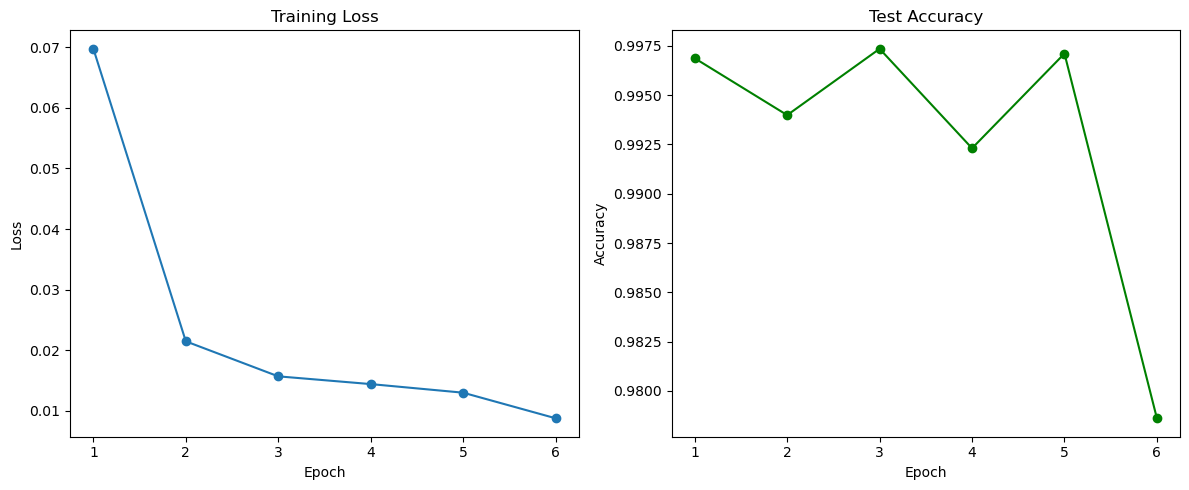

In [38]:
# Plot training loss and test accuracy
epochs_range = list(range(1, len(train_losses) + 1))  # [1, 2, 3] if 3 epochs

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range)  # set exact x-ticks

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, marker='o', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)  # set exact x-ticks

plt.tight_layout()
plt.show()

In [43]:
accuracy, all_preds, all_labels = evaluate(model, test_dataset)
print(f"Test accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

        REAL       0.96      1.00      0.98      2085
        FAKE       1.00      0.96      0.98      2075

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160

Test accuracy: 0.9786


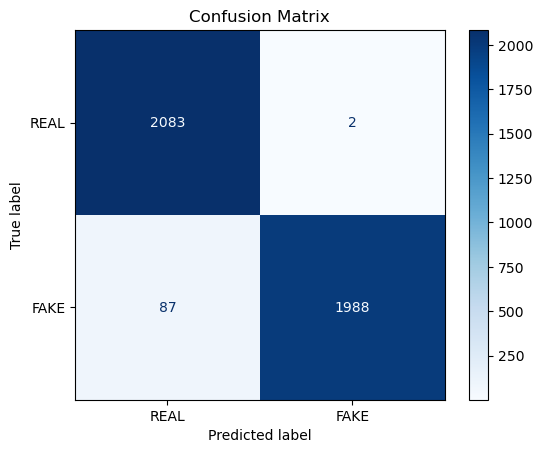

Misclassified Samples:
Predicted: 0, Actual: 1
Text: Wakame Seaweed Salad May Lower Blood Pressure Michael Greger M.D. FACLM
------
Predicted: 0, Actual: 1
Text: Comment on Selected not Elected — Rothschilds Hold $100,000 a Plate Dinner Fundraiser for Guess Who by Bruce Baker Bruce Baker
------
Predicted: 0, Actual: 1
Text: With Bridgegate Convictions Comes Calls To Impeach Chris Christie Dan Wright
------
Predicted: 0, Actual: 1
Text: 45 Weird Bans on Women in Iran Dr. Majid Rafizadeh
------
Predicted: 0, Actual: 1
Text: Daughter of Eric Garner Slams Clinton Camp Over Plans to ‘Use’ Her Father’s Death Cassandra Fairbanks
------
Predicted: 0, Actual: 1
Text: Comment on Philippines Voids Building Permit Of Trump Tower In Makati City by Shirley Barnett Shirley Barnett
------
Predicted: 0, Actual: 1
Text: Can You Get a Stunning and Healthy Smile with Coconut Oil? Jenn Ryan
------
Predicted: 0, Actual: 1
Text: A Trump Supporter Just Held Six Children At Gunpoint For Dumbest Reason Ever Jam

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Misclassified samples
print("Misclassified Samples:")
for i in range(len(all_preds)):
    if all_preds[i] != all_labels[i]:
        print(f"Predicted: {all_preds[i]}, Actual: {all_labels[i]}")
        print(f"Text: {X_test[i]}")  # Ensure X_test is correctly defined
        print("------")


In [47]:
# torch.save(model.state_dict(), 'bert_model.pth')
